In [189]:
import graph_tool.all as gt
import random
import numpy as np

In [74]:
name[0]

''

In [366]:
g = gt.Graph(directed=False)
name = g.vp["name"] = g.new_vp("string")
kind = g.vp["kind"] = g.new_vp("int")
weight = g.ep["count"] = g.new_ep("int")


D = 100
W = 20
W1 = 10

for i in range(D):
    n = g.add_vertex()
    name[n]=i
    kind[n]=0
        
for i in range(W):
    n = g.add_vertex()
    name[n]=i+D
    kind[n]=1
    
for i in range(W1):
    n = g.add_vertex()
    name[n]=i+D+W
    kind[n]=2
    
for i in range(D):
    for j in range(W):
        e = g.add_edge(i,j+D, False)
        weight[e] = int(random.randint(1,5))
    for j in range(W1):
        e = g.add_edge(i,j+D+W, False)
        weight[e] = int(random.randint(1,5))

In [367]:
for _ in range(1000):
    i = random.randint(0, D-1)
    j = random.randint(D, D+W-1)
    e = g.add_edge(i, j, False)
    weight[e] = random.randint(1,100)

In [368]:
len(list(g.vertices())),len(list(g.edges()))

(130, 4000)

In [369]:
clabel = g.vp['kind']
state_args = {'clabel': clabel, 'pclabel': clabel}
state_args["eweight"] = g.ep.count

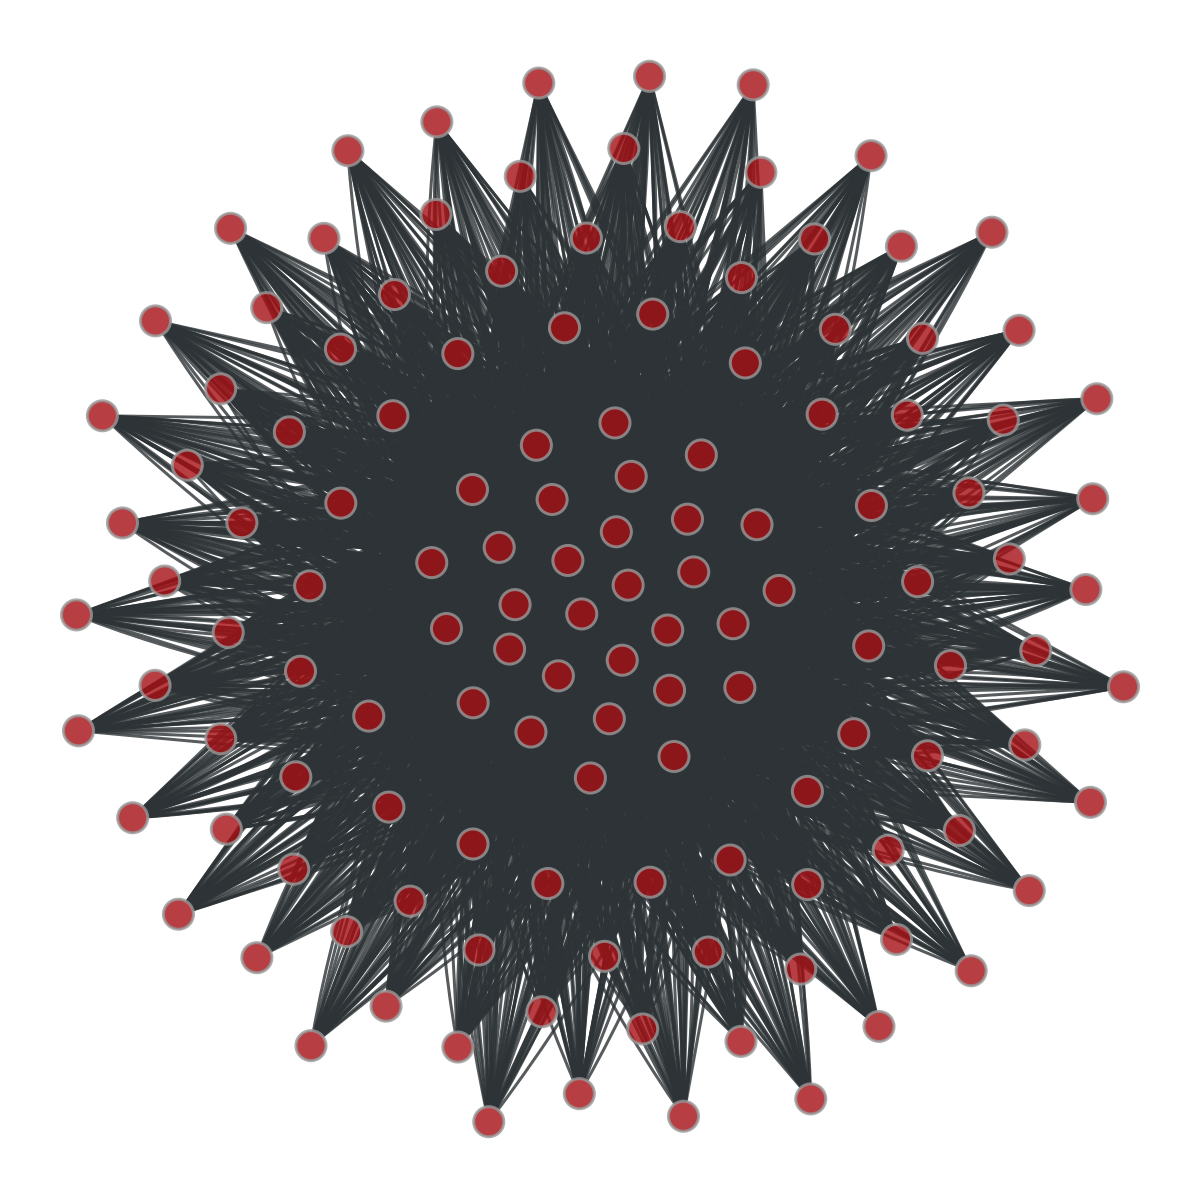

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb0a245b850, at 0x7fb0a232c250>

In [370]:
gt.graph_draw(g)

In [371]:
state = gt.minimize_nested_blockmodel_dl(g, 
                                deg_corr=True,
                                overlap=False,
                                state_args=state_args,
                                mcmc_args={'sequential': False},
                                mcmc_equilibrate_args={'mcmc_args': {'sequential': False}},
                                mcmc_multilevel_args={
                                      'mcmc_equilibrate_args': {
                                          'mcmc_args': {'sequential': False}
                                      },
                                      'anneal_args': {
                                          'mcmc_equilibrate_args': {
                                               'mcmc_args': {'sequential': False}
                                          }
                                      }
                                  })

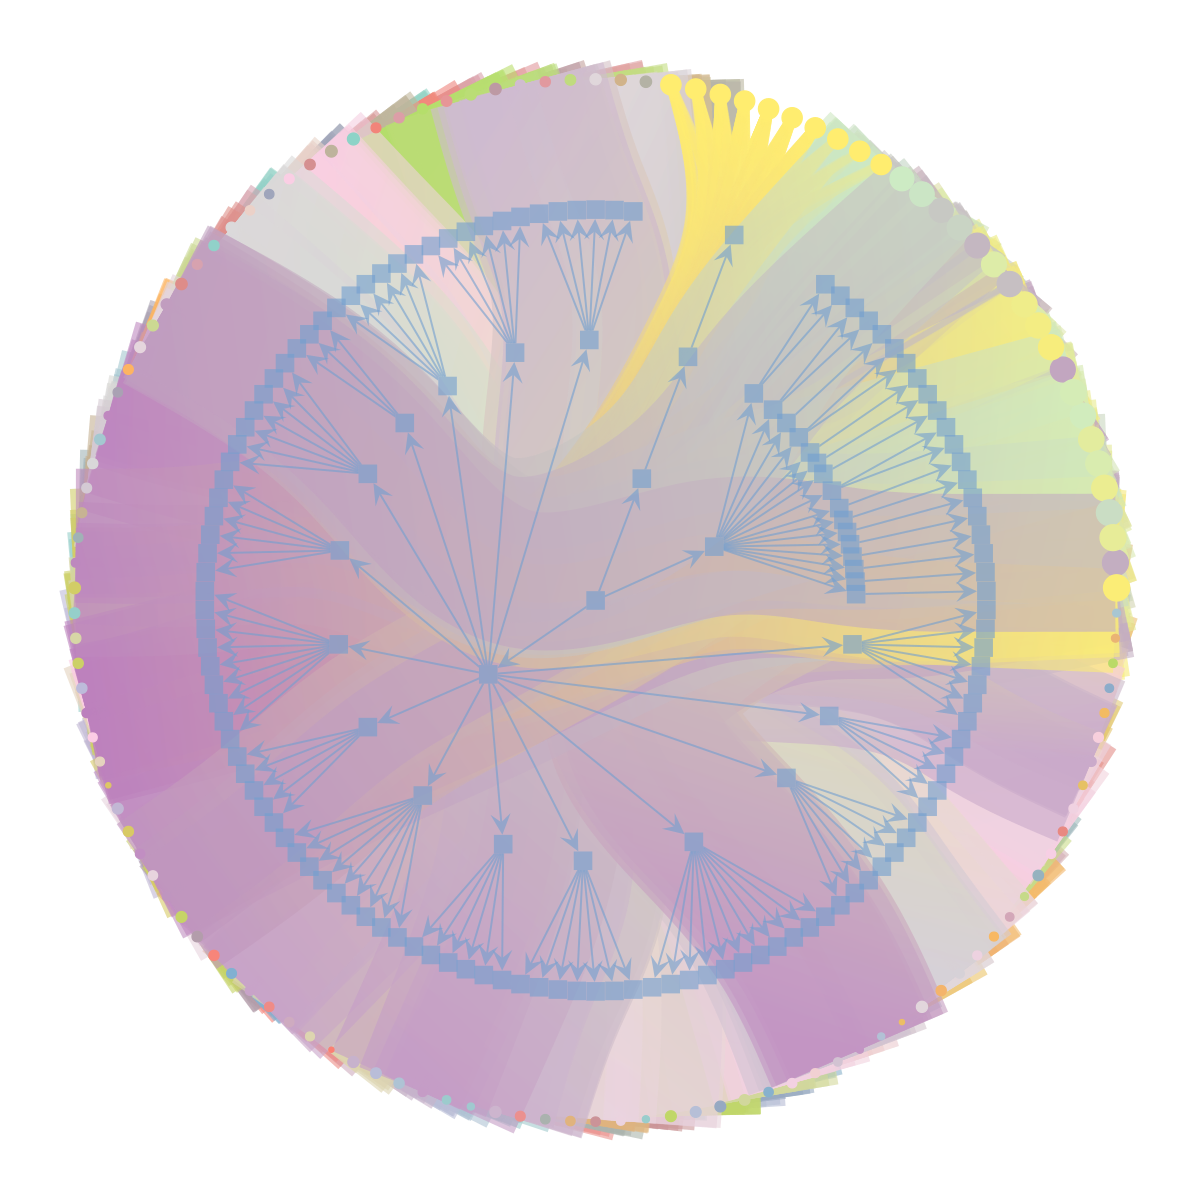

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb0a245b850, at 0x7fb0a2434a00>,
 <Graph object, directed, with 287 vertices and 286 edges, at 0x7fb0a1f19250>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb0a1f19250, at 0x7fb0a2434cd0>)

In [379]:
state.draw(subsample_edges=5000,
          edge_pen_width=g.ep["count"])

In [380]:
l=1
state_l = state.project_level(l).copy(overlap=True)
state_l_edges = state_l.get_edge_blocks()

In [381]:
B = state_l.B
D = int(np.sum(g.vp['kind'].a == 0))
W = int(np.sum(g.vp['kind'].a == 1))
W1 = int(np.sum(g.vp['kind'].a == 2))

n_dbw = np.zeros((D, B))
n_dbw_special = np.zeros((D, B))

for e in g.edges():
    z1, z2 = state_l_edges[e]
    v1 = e.source()
    v2 = e.target()
    if v2 < D + W:
        n_dbw[int(v1), z2] += 1
    else:
        n_dbw_special[int(v1), z2] += 1

In [382]:
#p_w = np.sum(n_wb, axis=1) / float(np.sum(n_wb))

#ind_d = np.where(np.sum(n_db, axis=0) > 0)[0]
#Bd = len(ind_d)
#n_db = n_db[:, ind_d]

#ind_w = np.where(np.sum(n_wb, axis=0) > 0)[0]
#Bw = len(ind_w)
#n_wb = n_wb[:, ind_w]

ind_w2 = np.where(np.sum(n_dbw, axis=0) > 0)[0]
n_dbw = n_dbw[:, ind_w2]

## Mixture of word-groups into documetns P(t_w | d)
p_tw_d = (n_dbw / np.sum(n_dbw, axis=1)[:, np.newaxis]).T

ind_w2_special = np.where(np.sum(n_dbw_special, axis=0) > 0)[0]
n_dbw_special = n_dbw_special[:, ind_w2_special]

## Mixture of word-groups into documetns P(t_w | d)
p_tw_d = (n_dbw / np.sum(n_dbw, axis=1)[:, np.newaxis]).T

## Mixture of word-groups into documetns P(t_w | d)
p_tw_d_special = (n_dbw_special / np.sum(n_dbw_special, axis=1)[:, np.newaxis]).T

result = {}
result['p_tw_d'] = p_tw_d
result['p_tspecialw_d'] = p_tw_d_special

In [383]:
result['p_tw_d'].shape

(16, 100)

In [384]:
result['p_tspecialw_d'].shape

(1, 100)